<a href="https://colab.research.google.com/github/ricds/DL_RS_GEE/blob/main/DL_UNet_CropExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Deep Learning with remote sensing data for image segmentation: example of rice crop mapping using Sentinel-2 images**

Ricardo Dalagnol, Fabien Wagner

<br>

**Goal of this notebook:**<br>
Train a deep learning model (U-Net) for image segmentation (rice crop) based on Sentinel-2 satellite images. Pre-processing and post-processing are done locally, thus in the Colab we only do the Deep Learning parts that require GPU.

<br>**Important note:** Make sure to set your Colab notebook to *R* and *GPU* at the Runtime/type menu.

<br>For this example we will use the basis of the U-Net model (Figure 1, Ronneberger et al., 2015), which have been used with success for many Earth Observation problems (Wagner et al., 2020a, 2020b). There are lots of other models out there you can test, such as ResNet, DeepLab, etc.<br><br>

<img src='https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png' width = 800>

Figure 1 - U-Net architecture. 

<br><br>**Contact** <br>
Ricardo Dal'Agnol da Silva<br>
National Institute for Space Research (INPE)<br>
Earth Observation and Geoinformatics Division (DIOTG)<br>
São José dos Campos-SP, Brazil<br>
e-mails: ricds@hotmail.com ; ricardo.silva@inpe.br<br>
phone: +55 12 98208-5089<br>
https://ricds.wordpress.com/<br>


## Config

First we install/load some packages necessary to run the deep learning.

In Colab we don't need to install GPU or anything like that. It already comes installed for us. For applications in local computer, you need to install the GPU/CUDA, python environment, etc. all by yourself. Take a look at this link for a guide on get DL running on your computer with GPU: https://doi.org/10.5281/zenodo.3929709

In [ ]:
#@title **Install packages (~4 min)**
install.packages("pacman")
library(pacman)

# # for rgee
# system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
# system('sudo apt-get update')
# system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')
# system('sudo apt-get install libprotobuf-dev protobuf-compiler libv8-dev libjq-dev')
# p_load(sf, mapview, cptcity, geojsonio)
# #install.packages('sf')
# #install.packages('mapview')
# #install.packages('cptcity')
# #install.packages('geojsonio')
# #remotes::install_github("r-spatial/rgee@rgeev.1.0.3")
# p_load(leaflet, rgdal, raster, sp, rgeos, gdalUtils, parallel, doParallel, foreach, fasterize, spatstat, maptools)


# install packages for deep learning - ~4 min to load
p_load(raster, sp)
p_load(devtools, tensorflow, reticulate, keras, tfdatasets, tidyverse, rsample, rgdal)
#new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
#if(length(new.packages)) install.packages(new.packages)
#lapply(list.of.packages, require, character.only = TRUE)
devtools::install_github("rstudio/keras") 
p_load(keras)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sp’



raster installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’



tensorflow installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’



keras installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


tfdatasets installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘warp’, ‘furrr’, ‘slider’



rsample installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


rgdal installed





✔  checking for file ‘/tmp/Rtmp3MZQ2y/remotes4b4f4b2744/rstudio-keras-d4804da/DESCRIPTION’
─  preparing ‘keras’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts (575ms)
─  checking for empty or unneeded directories
   Removed empty directory ‘keras/man-roxygen’
─  building ‘keras_2.6.0.9001.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#@title Download datasets

# download dataset
download.file('https://zenodo.org/record/5498424/files/input_training.zip?download=1', '/content/input_training.zip')
download.file('https://zenodo.org/record/5498424/files/input_prediction.zip?download=1', '/content/input_prediction.zip')
download.file('https://zenodo.org/record/5498480/files/grid.zip?download=1', '/content/grid.zip')
download.file('https://zenodo.org/record/5504554/files/ARROZ-RS_Safra_2019_2020.zip?download=1', '/content/ARROZ-RS_Safra_2019_2020.zip')

# unzip
unzip(zipfile='/content/input_training.zip', exdir="5_sampling1_singledate/input")
unzip(zipfile='/content/input_prediction.zip', exdir="6_sampling1_prediction_singledate/pred_input")
unzip(zipfile='/content/grid.zip', exdir="4_grid")
unzip(zipfile="/content/ARROZ-RS_Safra_2019_2020.zip", exdir=".")

# download unet weight
dir.create("/content/5_sampling1_singledate/weights_r_save/")
download.file('https://zenodo.org/record/5498488/files/unet_tf2_385_0.9311.h5?download=1', '/content/5_sampling1_singledate/weights_r_save/unet_tf2_385_0.9311.h5')

In [ ]:
#@title Set some variables

# set up deep learning
result_fname = "rice_map_singledate"
training_data_dir = "5_sampling1_singledate"
prediction_data_dir = "6_sampling1_prediction_singledate"
# 
img_dir = paste0(training_data_dir, "/input/image")
class_dir = paste0(training_data_dir,"/input/class")

In [ ]:
#@title Functions
# function to extract data from a raster (x) from a SpatialPolygons object (y) faster than extract()
fast_extract = function(x,y) {
  value = list()
  for (i in 1:length(y)) {
    tmp = crop(x, y[i,])
    #value[[i]] = extract(tmp, y[i,])
    value[[i]] = as.numeric(na.omit(mask(tmp, y[i,])[]))
    rm(tmp)
  }
  return(value)
}

# function to extract data from a raster (x) from a SpatialPolygons object (y) faster than extract()
fast_extract_parallel = function(x,y) {
  
  # libraries needed
  require(parallel) # install.packages("parallel")
  require(doParallel) # install.packages("doParallel")
  require(foreach) # install.packages("foreach")
  
  # Begin cluster
  cl = parallel::makeCluster(detectCores()-1) # here you specify the number of processors you want to use, if you dont know you can use detectCores() and ideally use that number minus one
  #cl = parallel::makeCluster(3, outfile="D:/r_parallel_log.txt") # if you use this you can see prints in the txt
  registerDoParallel(cl)
  
  # apply the model in parallel
  # sometimes you need to specify in the package parameter (.packages) the name of package of the functions you are using
  value = foreach(i=1:length(y)) %dopar% { # note the %dopar% here
    require(raster)
    return(as.numeric(na.omit(mask(crop(x, y[i,]), y[i,])[])))
  }
  
  return(value)
}

# function to get the sp with the extent of a raster object
rasext_to_sp = function(x) {
  y = as(extent(x), "SpatialPolygons")
  crs(y) = crs(x)
  return(y)
}

# convert raster to vector using gdal_polygonize
# this version accept the python path and poligonizer path separetely
polygonizer_v2 <- function(x, outshape=NULL, pypath=NULL, polipath = NULL, readpoly=TRUE, 
                           fillholes=FALSE, aggregate=FALSE, 
                           quietish=TRUE) {
  # x: an R Raster layer, or the file path to a raster file recognised by GDAL 
  # outshape: the path to the output shapefile (if NULL, a temporary file will 
  #           be created) 
  # pypath: the path to gdal_polygonize.py or OSGeo4W.bat (if NULL, the function 
  #         will attempt to determine the location)
  # readpoly: should the polygon shapefile be read back into R, and returned by
  #           this function? (logical) 
  # fillholes: should holes be deleted (i.e., their area added to the containing
  #            polygon)
  # aggregate: should polygons be aggregated by their associated raster value?
  # quietish: should (some) messages be suppressed? (logical)
  if (isTRUE(readpoly) || isTRUE(fillholes)) require(rgdal)
  
  #cmd <- Sys.which(paste0(pypath, '\\OSGeo4W.bat'))
  cmd = pypath
  if (is.null(pypath) | is.null(polipath)) {
    stop("Could not find gdal_polygonize.py or OSGeo4W on your system.")
  }
  if (!is.null(outshape)) {
    outshape <- sub('\\.shp$', '', outshape)
    f.exists <- file.exists(paste(outshape, c('shp', 'shx', 'dbf'), sep='.'))
    if (any(f.exists))
      stop(sprintf('File already exists: %s',
                   toString(paste(outshape, c('shp', 'shx', 'dbf'),
                                  sep='.')[f.exists])), call.=FALSE)
  } else outshape <- tempfile()
  if (is(x, 'Raster')) {
    require(raster)
    writeRaster(x, {f <- tempfile(fileext='.tif')})
    rastpath <- normalizePath(f)
  } else if (is.character(x)) {
    rastpath <- normalizePath(x)
  } else stop('x must be a file path (character string), or a Raster object.')
  
  # system2(cmd, args=(
  #   sprintf('"%s" "%s" %s -f "ESRI Shapefile" "%s.shp"', 
  #           pypath, rastpath, ifelse(quietish, '-q ', ''), outshape)))
  system2(cmd, sprintf('"%s" "%s" %s -f "ESRI Shapefile" "%s.shp"', 
                       polipath, rastpath, ifelse(quietish, '-q ', ''), outshape))
  
  if(isTRUE(aggregate)||isTRUE(readpoly)||isTRUE(fillholes)) {
    shp <- readOGR(dirname(outshape), layer=basename(outshape), 
                   verbose=!quietish)    
  } else return(NULL)
  
  if (isTRUE(fillholes)) {
    poly_noholes <- lapply(shp@polygons, function(x) {
      Filter(function(p) p@ringDir==1, x@Polygons)[[1]]
    })
    pp <- SpatialPolygons(mapply(function(x, id) {
      list(Polygons(list(x), ID=id))
    }, poly_noholes, row.names(shp)), proj4string=CRS(proj4string(shp)))
    shp <- SpatialPolygonsDataFrame(pp, shp@data)
    if(isTRUE(aggregate)) shp <- aggregate(shp, names(shp))
    writeOGR(shp, dirname(outshape), basename(outshape), 
             'ESRI Shapefile', overwrite=TRUE)
  }
  if(isTRUE(aggregate) & !isTRUE(fillholes)) {
    shp <- aggregate(shp, names(shp))
    writeOGR(shp, dirname(outshape), basename(outshape), 
             'ESRI Shapefile', overwrite=TRUE)
  }
  ifelse(isTRUE(readpoly), return(shp), return(NULL))
}

# function from spatial.tools (does not work in R4.0.2 yet so we copied from previous version)
modify_raster_margins = function (x, extent_delta = c(0, 0, 0, 0), value = NA) 
{
  x_extents <- extent(x)
  res_x <- res(x)
  x_modified <- x
  if (any(extent_delta < 0)) {
    ul_mod <- extent_delta[c(1, 3)] * res_x
    ul_mod[ul_mod > 0] <- 0
    lr_mod <- extent_delta[c(2, 4)] * res_x
    lr_mod[lr_mod > 0] <- 0
    crop_extent <- c(x_extents@xmin, x_extents@xmax, x_extents@ymin, 
                     x_extents@ymax)
    crop_extent[c(1, 3)] <- crop_extent[c(1, 3)] - ul_mod
    crop_extent[c(2, 4)] <- crop_extent[c(2, 4)] + lr_mod
    x_modified <- crop(x_modified, crop_extent)
  }
  if (any(extent_delta > 0)) {
    ul_mod <- extent_delta[c(1, 3)] * res_x
    ul_mod[ul_mod < 0] <- 0
    lr_mod <- extent_delta[c(2, 4)] * res_x
    lr_mod[lr_mod < 0] <- 0
    extend_extent <- c(x_extents@xmin, x_extents@xmax, x_extents@ymin, 
                       x_extents@ymax)
    extend_extent[c(1, 3)] <- extend_extent[c(1, 3)] - ul_mod
    extend_extent[c(2, 4)] <- extend_extent[c(2, 4)] + lr_mod
    x_modified <- extend(x_modified, extend_extent, value = value)
  }
  return(x_modified)
}


# split the extent of a sp object
split_extent_gdal = function(x, block_size = 1000, na_rm = T, remove_all_zero = T, gdal_path = NULL) {
  if (is.null(gdal_path)) stop("Missing GDAL path.")
  # x = LIDAR_ANA_2017
  # x = LIDAR_ST1_2016
  x_ext = extent(x)
  
  # create a temporary raster within the extent with block_size as pixel size
  #n_x = ceiling(abs((x_ext[2] - x_ext[1])) / block_size)
  n_y = abs((x_ext[4] - x_ext[3])) / block_size
  # adjust extent to fit the cells
  x_ext_mod = x_ext
  x_ext_mod[4] = x_ext_mod[4] + ((ceiling(n_y) - n_y) * block_size)
  #
  r = raster(x_ext_mod, crs = crs(x), resolution = block_size)
  r[] = NA
  #
  #plot(extend(extent(r),100), asp=1)
  #plot(r, add=T, col="red")
  fname = paste0(tempfile(), ".tif")
  writeRaster(r, filename = fname, overwrite=T)
  
  if (inMemory(x)) {
    fname_x = paste0(tempfile(), "_x.tif")
    writeRaster(x, filename = fname_x)
    x = raster(fname_x)
  }
  
  # calculate the average of x inside the pixels
  #gdal_path = "C:\\GDAL_64\\"
  # command
  # gdalwarp = paste(paste0(gdal_path,"gdalwarp")
  #                  #,"-r average -wm 9999"
  #                  ,"-r average -wm 2047"
  #                  ,x@file@name
  #                  ,fname
  # )
  # system(gdalwarp)
  gdalUtils::gdalwarp(srcfile = x@file@name, dstfile = fname)
  
  # load
  r2 = raster(fname)
  #plot(r2)
  
  # convert raster to polygons - only those with values
  r2_pol = rasterToPolygons(r2, dissolve=F, na.rm=na_rm)
  # plot(r2_pol)
  
  # exclude all zero
  if (remove_all_zero) {
    idx = which(r2_pol@data[]==0)
    if (length(idx) > 0) r2_pol = r2_pol[-idx,]
  }
  
  # create extents
  ext_list = list()
  i=1
  for (i in 1:length(r2_pol)) {
    ext_list[[i]] = extent(r2_pol[i,])
  }
  
  unlink(fname)
  
  return(ext_list)
}
#


# split the extent of a sp object
split_extent_gdal_bottom = function(x, block_size = 1000, na_rm = T, remove_all_zero = T, gdal_path = NULL) {
  if (is.null(gdal_path)) stop("Missing GDAL path.")
  # x = LIDAR_ANA_2017
  # x = LIDAR_ST1_2016
  x_ext = extent(x)
  
  # create a temporary raster within the extent with block_size as pixel size
  #n_x = ceiling(abs((x_ext[2] - x_ext[1])) / block_size)
  n_y = abs((x_ext[4] - x_ext[3])) / block_size
  # adjust extent to fit the cells
  x_ext_mod = x_ext
  #x_ext_mod[4] = x_ext_mod[4] + ((ceiling(n_y) - n_y) * block_size)
  x_ext_mod[3] = x_ext_mod[3] - ((ceiling(n_y) - n_y) * block_size)
  #
  r = raster(x_ext_mod, crs = crs(x), resolution = block_size)
  r[] = NA
  #
  #plot(extend(extent(r),100), asp=1)
  #plot(r, add=T, col="red")
  fname = paste0(tempfile(), ".tif")
  writeRaster(r, filename = fname, overwrite=T)
  
  if (inMemory(x)) {
    fname_x = paste0(tempfile(), "_x.tif")
    writeRaster(x, filename = fname_x)
    x = raster(fname_x)
  }
  
  # calculate the average of x inside the pixels
  #gdal_path = "C:\\GDAL_64\\"
  # command
  gdalwarp = paste(paste0(gdal_path,"gdalwarp")
                   #,"-r average -wm 9999"
                   ,"-r average -wm 2047"
                   ,x@file@name
                   ,fname
  )
  system(gdalwarp)
  
  # load
  r2 = raster(fname)
  #plot(r2)
  
  # convert raster to polygons - only those with values
  r2_pol = rasterToPolygons(r2, dissolve=F, na.rm=na_rm)
  # plot(r2_pol)
  
  # exclude all zero
  if (remove_all_zero) {
    idx = which(r2_pol@data[]==0)
    if (length(idx) > 0) r2_pol = r2_pol[-idx,]
  }
  
  # create extents
  ext_list = list()
  i=1
  for (i in 1:length(r2_pol)) {
    ext_list[[i]] = extent(r2_pol[i,])
  }
  
  unlink(fname)
  
  return(ext_list)
}
#

# function to remove the last 4 digits of a string (usually the extension e.g. ".tif") and substitute it for another string
sub_extension = function (x, y) {
  return(paste0(substr(x, 1, nchar(x)-4), y))
}


# 1) Field samples

In this section we download and load a dataset of rice crop locations from the CONAB Brazilian government organization for the Brazilian state of Rio Grande do Sul. This dataset and more can be found here https://portaldeinformacoes.conab.gov.br/mapeamentos-agricolas.html

We filter the data for only one municipality (Uruguaiana) to run the experiments.

OGR data source with driver: ESRI Shapefile 
Source: "/content/RS_ARROZ_IRRIG_INUND_1920.shp", layer: "RS_ARROZ_IRRIG_INUND_1920"
with 26641 features
It has 4 fields
Integer64 fields read as strings:  id 
class       : SpatialPolygonsDataFrame 
features    : 2414 
extent      : -57.31271, -56.16286, -30.19332, -29.42392  (xmin, xmax, ymin, ymax)
crs         : +proj=longlat +ellps=GRS80 +no_defs  
variables   : 4
names       :    id, area_ha, NM_MUNICIP, CD_GEOCMU 
min values  : 10130,     0.1, URUGUAIANA,   4322400 
max values  : 12547,   649.2, URUGUAIANA,   4322400 


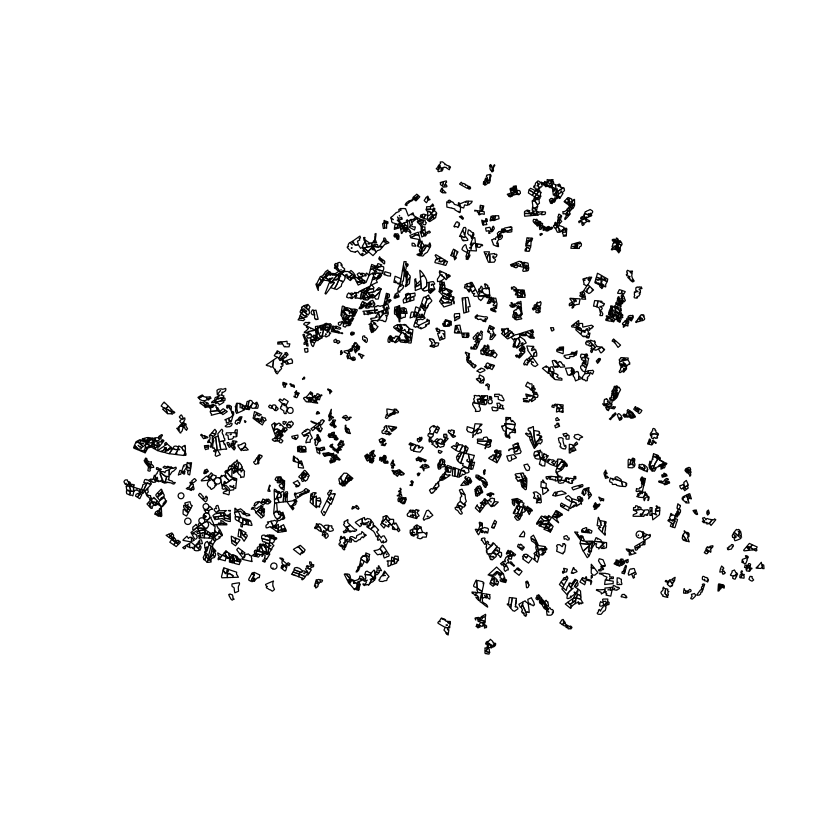

In [ ]:
#if (FALSE)  {

# load field data
field_data = readOGR("RS_ARROZ_IRRIG_INUND_1920.shp")

# lets filter these data to only one municipality, list municipalities and get only one
#unique(field_data$NM_MUNICIP)

# use uruguaiana as an example
field_data = field_data[field_data$NM_MUNICIP == "URUGUAIANA",]
print(field_data)

# reproject to the same projection of the satellite data
field_data = spTransform(field_data, crs("+proj=utm +zone=21 +south +datum=WGS84 +units=m +no_defs"))

# visualize
plot(field_data)

#}

# # load data
# field_data_sf = st_read("RS_ARROZ_IRRIG_INUND_1920.shp")
# field_data_sf = st_transform(field_data_sf, crs("+proj=utm +zone=21 +south +datum=WGS84 +units=m +no_defs"))

# # use uruguaiana as an example
# field_data_sf = field_data_sf[field_data_sf$NM_MUNICIP == "URUGUAIANA",]
# print(field_data_sf)
# plot(st_geometry(field_data_sf))


# # create convex hull around the polygons
# p_load(rgeos)
# field_data_convex = gConvexHull(field_data)
# field_data_convex$id = 1
# plot(field_data_convex, main="convex hull")

[1] 1863

class      : RasterStack 
dimensions : 128, 128, 16384, 4  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0, 128, 0, 128  (xmin, xmax, ymin, ymax)
crs        : NA 
names      : img_YES_06265.1, img_YES_06265.2, img_YES_06265.3, img_YES_06265.4 
min values :               0,               0,               0,               0 
max values :             255,             255,             255,             255 


[1] 1554


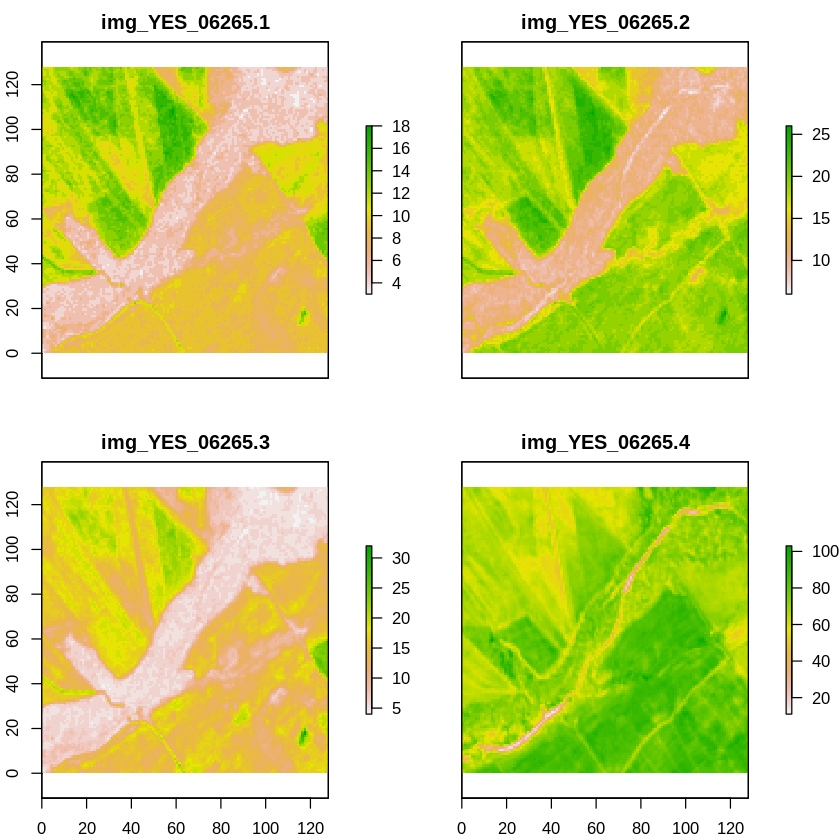

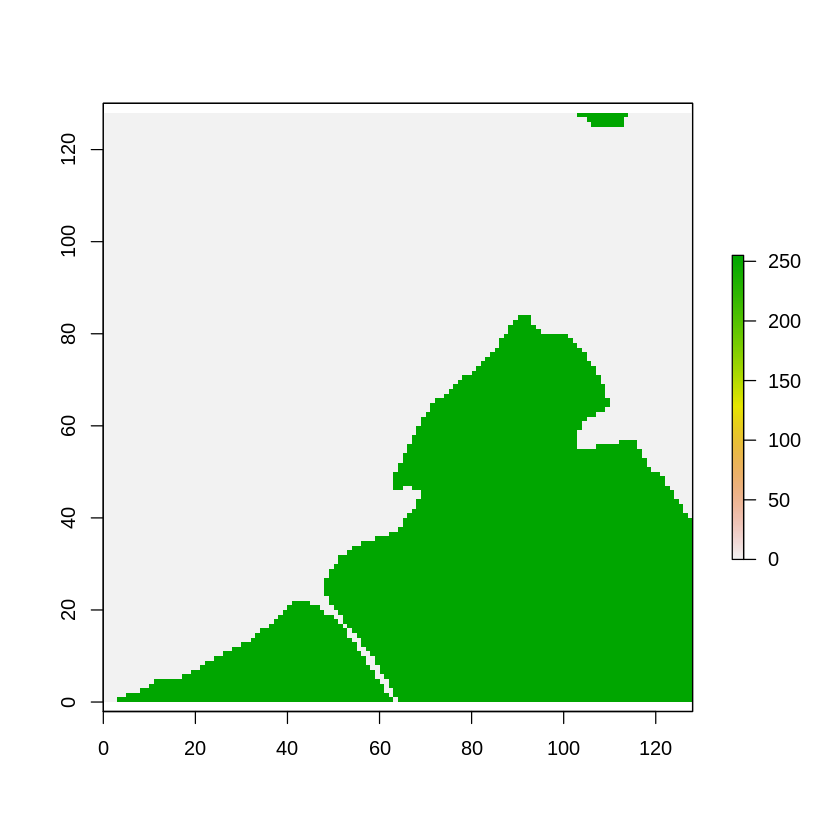

In [ ]:
#@title Visualize some patch samples

# list samples
list_img = list.files(img_dir, pattern = "*.png", full.names = TRUE)
list_mask = list.files(class_dir, pattern = "*.png", full.names = TRUE)
length(list_img)

# plot
# i=1
i = sample(1:length(list_img), 1)
r = stack(list_img[i])
plot(r)
r
print(i)
plot(raster(list_mask[i]))

# 2) Deep Learning Training

OGR data source with driver: ESRI Shapefile 
Source: "/content/4_grid/grid.shp", layer: "grid"
with 8670 features
It has 2 fields


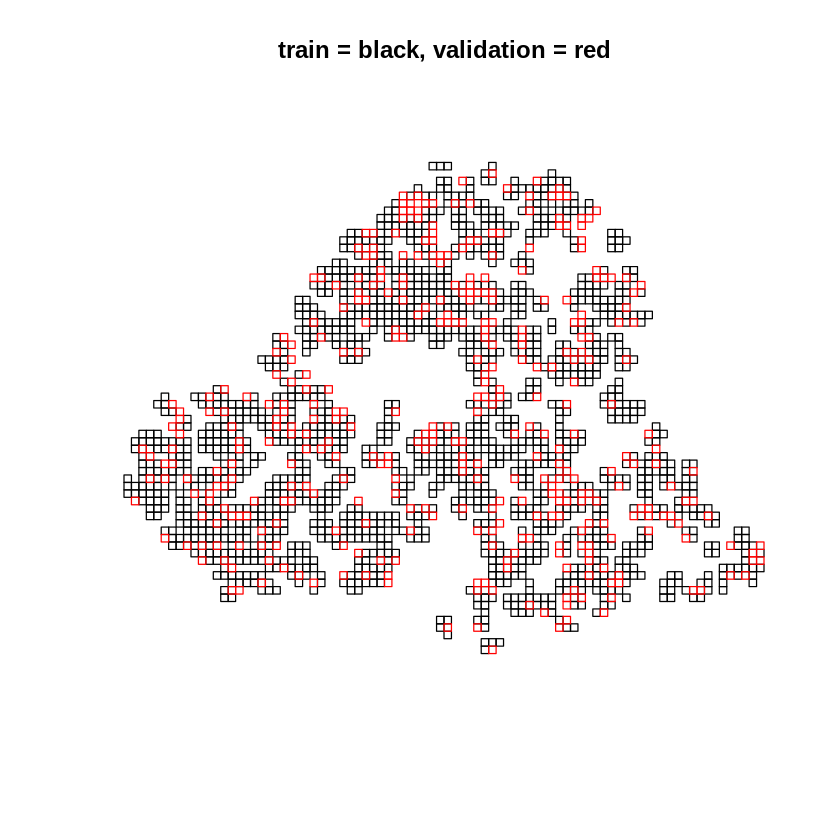

In [ ]:
#@title DL stratify samples 

# libraries we're going to need later
# always put reticulate and use_python as the first packages to load, or you will not be able to choose the conda env/python
#library("reticulate")
p_load(reticulate, keras, tfdatasets, tidyverse, rsample)
#use_python("C:\\ProgramData\\Miniconda3\\envs\\r-tensorflow", required = T) #use_python("C:\\Users\\Ricardo\\Miniconda3\\envs\\r-tensorflow", required = T)
#library(keras)
#library(tfdatasets)
#library(tidyverse)
#library(rsample)
#py_config()


# load all data
data_full <- tibble(
  img = list.files(img_dir, pattern = "*.png", full.names = TRUE),
  mask = list.files(class_dir, pattern = "*.png", full.names = TRUE)
)

# random sorting of the data
set.seed(10)
random_order=sample(1:dim(data_full)[1],dim(data_full)[1])
data_full_reorder <- data_full[random_order,]

# split the data between training and validation
data_full_reorder <- initial_split(data_full_reorder, prop = 0.8)
train_samples = length(data_full_reorder$in_id)
train_fname = training(data_full_reorder)$img
test_fname = testing(data_full_reorder)$img

# (OPTIONAL, only if needed) some additional filtering
# in my case i need this because i have samples from four different images with different names (img_1, img_2, img_3, img_4), so i need to pick one
#img_list = grep(paste0("img_",j), img_list, value=T)
#img_list = grep(paste0(transect_name,"_tchm_",j), img_list, value=T)
#img_list = grep(paste0(transect_name,"_tchm"), img_list, value=T)

# find the id on the name of imgs string
idx_last_underline = regexpr("\\_[^\\_]*$", basename(test_fname)[1])[1]
ids_validation = as.numeric(substr(basename(test_fname), idx_last_underline + 1, nchar(basename(test_fname))[1] - 4))

# find the id on the name of imgs string
idx_last_underline = regexpr("\\_[^\\_]*$", basename(train_fname)[1])[1]
ids_train = as.numeric(substr(basename(train_fname), idx_last_underline + 1, nchar(basename(train_fname))[1] - 4))

# get the polygons inside each block id
grid = readOGR("4_grid/grid.shp")
samples_patches_validation = grid[grid$id %in% ids_validation,]
samples_patches_train = grid[grid$id %in% ids_train,]
plot(samples_patches_train, main="train = black, validation = red")
lines(samples_patches_validation, col="red")

# save
save(samples_patches_train, samples_patches_validation, file = "deep_learning_patch_samples_singledate.RData")



In [ ]:
#@title DL training U-Net (~7min for 15 iterations)

# parameters
epochs = 15L # 400L
batch_size = 32L
lr_rate = 0.0001
decay_rate = 0.0001
data_n_layers = 4

## the model

# mixed precision
tf$keras$mixed_precision$experimental$set_policy('mixed_float16')

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

bce_dice_loss <- function(y_true, y_pred) {
  result <- loss_binary_crossentropy(y_true, y_pred) +
    (1 - dice_coef(y_true, y_pred))
  return(result)
}

#
get_unet_128 <- function(input_shape = c(128, 128, data_n_layers),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            dtype = 'float32', # mixed precision
                            activation = "sigmoid")
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = lr_rate, decay = decay_rate),
    loss = bce_dice_loss,
    #loss = bce_dice_loss_flooding,
    metrics = c(dice_coef)
  )
  
  return(model)
}
#
model <- get_unet_128()






## data augmentation


# random brightness, contrast, hue
random_bsh <- function(img) {
  img <- img %>%
    tf$image$random_brightness(max_delta = 0.2) %>%
    tf$image$random_contrast(lower = 0.9, upper = 1.1) # %>%
  
  # img <- tf$math$multiply(img,tf$random$uniform(shape =  shape(1L), minval = 0.4 ,maxval = 1.6 ,dtype = tf$float32))
  
  # for RGB
  # img_aug <- img[,,1:3]  %>%
  #   tf$image$random_saturation(lower = 0.9, upper = 1.1) %>%
  #   tf$image$random_hue(max_delta = 0.2) #%>%
  # 
  # img <- tf$keras$backend$concatenate(
  #   list(img_aug[,,1:3,drop=FALSE],img[,,4,drop=FALSE]), axis=-1L
  # ) %>% tf$clip_by_value(0, 1)
  
}
random_flip_up_down <- function(x,y) { tf$cond(tf$less(y , 0.25) , function() tf$image$flip_up_down(x), function() x) }
random_flip_left_right <- function(x,y) { tf$cond(tf$greater(y , 0.75), function() tf$image$flip_left_right(x), function() x) }


# map data
create_dataset <- function(data, train, batch_size = 8L, data_n_layers = 3) {
  
  dataset <- data %>%  
    mutate(rot = ifelse(runif(dim(data)[1])>0.75,1,0)*runif(dim(data)[1],min=0,max=2*pi)) %>%
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img =  tf$image$decode_png(tf$io$read_file(.x$img),channels=data_n_layers),
      mask = tf$image$decode_png(tf$io$read_file(.x$mask),channels=1)
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
      #mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$uint8)
      mask = tf$image$convert_image_dtype(.x$mask, dtype = tf$float32)
    )) 
  
  # set rot variable to a random uniform value
  dataset <- dataset %>% dataset_map(~.x %>% list_modify(
    rot =tf$random$uniform(shape =  shape(1L), minval = 0 ,maxval = 1 ,dtype = tf$float32)
  ))
  
  # apply up/down and left/right flip conditioned by rot 
  dataset <- dataset  %>%
    dataset_map(~.x %>% list_modify(
      img = random_flip_up_down(x=.x$img,y=.x$rot),
      mask = random_flip_up_down(x=.x$mask,y=.x$rot)
    )) %>%
    dataset_map(~.x %>% list_modify(
      img = random_flip_left_right(x=.x$img,y=.x$rot),
      mask = random_flip_left_right(x=.x$mask,y=.x$rot)
    ))
  
  
  # data augmentation performed on training set only
  if (train) {
    dataset <- dataset %>%
      dataset_map(~.x %>% list_modify(
        img = random_bsh(.x$img)
      ))
  }
  
  # shuffling on training set only
  if (train) {
    dataset <- dataset %>%
      #  dataset_shuffle(buffer_size = batch_size*128) #
      dataset_shuffle(buffer_size = batch_size*128,seed=666,reshuffle_each_iteration=FALSE)
  }
  
  # train in batches; batch size might need to be adapted depending on
  # available memory
  dataset <- dataset %>% 
    dataset_batch(batch_size)
  
  dataset %>% 
    # output needs to be unnamed
    dataset_map(unname) 
}




## Train

# Training and test set creation now is just a matter of two function calls.
training_dataset <- create_dataset(training(data_full_reorder), train = TRUE, data_n_layers = data_n_layers)
validation_dataset <- create_dataset(testing(data_full_reorder), train = FALSE, data_n_layers = data_n_layers)

# callbacks
dir.create(paste0(training_data_dir, "/epoch_history/"), showWarnings=F)
dir.create(paste0(training_data_dir, "/weights/"), showWarnings=F)
dir.create(paste0(training_data_dir, "/weights_r_save/"), showWarnings=F)
callbacks_list <- list(
  callback_csv_logger(paste0(training_data_dir, "/epoch_history/epoch_history.csv"), separator = ";", append = FALSE),
  callback_model_checkpoint(filepath = paste0(training_data_dir, "/weights/unet_tf2_{epoch:03d}_{val_custom:.4f}.h5"),
                            monitor = "val_custom",save_best_only = TRUE,
                            save_weights_only = TRUE, mode = "max" ,save_freq = NULL)
)

## start training from a set of weights
# load_model_weights_hdf5(model, "./weights_r_save/unet_tf2_111_0.6083_noBSH.h5") # example

# train
training_dataset <- dataset_repeat(training_dataset, count = epochs)
model_history = fit_generator(model,training_dataset,validation_data = validation_dataset, workers = 1, steps_per_epoch = as.integer(train_samples / batch_size), epochs = epochs,callbacks = callbacks_list)

# how to print to console?
# https://stackoverflow.com/questions/37689694/real-time-printing-to-console-with-r-in-jupyter


# clear GPU
tf$keras.backend$clear_session()
py_gc <- import('gc')
py_gc$collect()





Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”
Warning message in fit_generator(model, training_dataset, validation_data = validation_dataset, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


[1] 8

`geom_smooth()` using formula 'y ~ x'



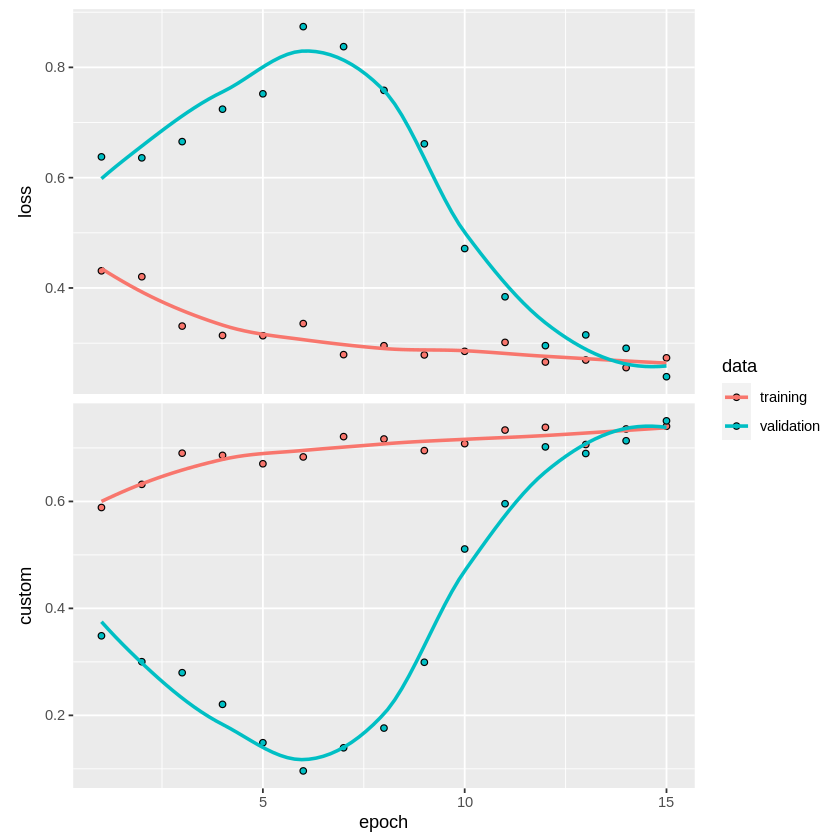

In [ ]:
#@title Visualize model performance during training

# visualize the acc
plot(model_history)

# 3) DL Prediction

We apply the best model to the whole image. This cell crops the image in multiple patches, apply the model, and then mosaic everything back together as a single image.

For prediction, we increase the size of the patches to make prediction faster. The size of this prediction is more or less *the size that fits in the memory*. So we use 640x640 (prediction) instead of 128x128 (training).

In [ ]:
#@title Prepare to predict

# location of the model weights file
weights_fname = "5_sampling1_singledate/weights_r_save/unet_tf2_385_0.9311.h5" # best weight

# libraries we're going to need later
# always put reticulate and use_python as the first packages to load, or you will not be able to choose the conda env/python
#library("reticulate")
p_load(reticulate, keras, tfdatasets, tidyverse, rsample)
#use_python("C:\\ProgramData\\Miniconda3\\envs\\r-tensorflow", required = T) #use_python("C:\\Users\\Ricardo\\Miniconda3\\envs\\r-tensorflow", required = T)
#library(keras)
#library(tfdatasets)
#library(tidyverse)
#library(rsample)
#py_config()

## Config

# config
batch_size = 4
data_n_layers = 4
lr_rate = 0.0001

# raster opts
dir.create(paste0(prediction_data_dir, "/tmp"), showWarnings = F)
rasterOptions(tmpdir="tmp")
#rasterOptions(maxmemory = 5e+10)
#rasterOptions(chunksize = 1e+09)


# path to the gdal files and to the osgeo .bat (to run gdal_polygonize)
#gdal_path = "C:\\OSGeo4W\\bin\\"
#osgeo_path = "C:\\OSGeo4W"

# create dirs
dir.create(paste0(prediction_data_dir, "/pred_input"), showWarnings = F, recursive=T)
dir.create(paste0(prediction_data_dir,"/pred_output"), showWarnings = F)
dir.create(paste0(prediction_data_dir,"/pred_mosaic"), showWarnings = F, recursive=T)
dir.create(paste0(prediction_data_dir,"/pred_vector"), showWarnings = F, recursive=T)

# clear some folders before starting
#unlink(list.files(paste0(prediction_data_dir, "/pred_input/"), full.names = TRUE))
unlink(list.files(paste0(prediction_data_dir, "/pred_output/"), full.names = TRUE))
unlink(list.files(paste0(prediction_data_dir, "/tmp/"), full.names = TRUE))



# load data
#img_list = list.files("2_Images", full.names=T)

# load
#predictor_data = stack(img_list)
#predictor_data_expand = stack(img_list)[[bands_to_use]]
# predictor_data_expand = stack("s2_blank.tif")


# # change NA to 0
# predictor_data[is.na(predictor_data),] = 0

# add borders
#predictor_data_expand = modify_raster_margins(predictor_data, extent_delta=c(64,64,64,64),value=0)
## not needed i think

# # adjust image to a multiple of 512 - for easier cropping
# n_row_tiles = ceiling(nrow(predictor_data)/512)
# n_row_add = (n_row_tiles * 512) - nrow(predictor_data)
# n_col_tiles = ceiling(ncol(predictor_data)/512)
# n_col_add = (n_col_tiles * 512) - ncol(predictor_data)
# predictor_data_expand = modify_raster_margins(predictor_data, extent_delta=c(0,n_col_add,0,n_row_add),value=0)


# # define the extents
# block_size = 512*10
# #predictor_data_ext = split_extent_gdal_bottom(x = predictor_data_expand[[1]], block_size = block_size, na_rm = F, remove_all_zero = F, gdal_path = gdal_path)
# p_load(gdalUtils)

# predictor_data_ext = split_extent_gdal_border_adj(x =predictor_data_expand, block_size = block_size, na_rm = T, remove_all_zero = F, gdal_path = "")
# length(predictor_data_ext)


In [ ]:
#@title predict all tiles (~7 min)

# load data
test_dir <- paste0(prediction_data_dir, "/pred_input/")
list_png=list.files(test_dir, pattern = "*.png$", full.names = TRUE)
length(list_png)

data <- tibble(
  img = list_png
)

## the model 

# mixed precision
tf$keras$mixed_precision$experimental$set_policy('mixed_float16')

dice_coef <- custom_metric("custom", function(y_true, y_pred, smooth = 1.0) {
  y_true_f <- k_flatten(y_true)
  y_pred_f <- k_flatten(y_pred)
  intersection <- k_sum(y_true_f * y_pred_f)
  result <- (2 * intersection + smooth) / 
    (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
  return(result)
})

bce_dice_loss <- function(y_true, y_pred) {
  result <- loss_binary_crossentropy(y_true, y_pred) +
    (1 - dice_coef(y_true, y_pred))
  return(result)
}

get_unet_128 <- function(input_shape = c(640, 640, data_n_layers),
                         num_classes = 1) {
  
  inputs <- layer_input(shape = input_shape)
  # 128
  
  down1 <- inputs %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down1_pool <- down1 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 64
  
  down2 <- down1_pool %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down2_pool <- down2 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 32
  
  down3 <- down2_pool %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down3_pool <- down3 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 16
  
  down4 <- down3_pool %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  down4_pool <- down4 %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2))
  # 8
  
  center <- down4_pool %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 1024, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") 
  # center
  
  up4 <- center %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down4, .), axis = 3)} %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 512, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 16
  
  up3 <- up4 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down3, .), axis = 3)} %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 256, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 32
  
  up2 <- up3 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down2, .), axis = 3)} %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 64
  
  up1 <- up2 %>%
    layer_upsampling_2d(size = c(2, 2)) %>%
    {layer_concatenate(inputs = list(down1, .), axis = 3)} %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu") %>%
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), padding = "same") %>%
    layer_batch_normalization() %>%
    layer_activation("relu")
  # 128
  
  classify <- layer_conv_2d(up1,
                            filters = num_classes, 
                            kernel_size = c(1, 1),
                            dtype = 'float32', # mixed precision
                            activation = "sigmoid")
  
  
  model <- keras_model(
    inputs = inputs,
    outputs = classify
  )
  
  model %>% compile(
    optimizer = optimizer_rmsprop(lr = lr_rate),
    loss = bce_dice_loss,
    metrics = c(dice_coef)
  )
  
  return(model)
}

model <- get_unet_128()

# map data
create_dataset <- function(data, batch_size = 4L, data_n_layers = 3) {
  
  dataset <- data %>%  
    tensor_slices_dataset() %>% 
    dataset_map(~.x %>% list_modify(
      img =  tf$image$decode_png(tf$io$read_file(.x$img), channels=data_n_layers),
    )) %>% 
    dataset_map(~.x %>% list_modify(
      img = tf$image$convert_image_dtype(.x$img, dtype = tf$float32),
    )) 
  
  # train in batches; batch size might need to be adapted depending on
  # available memory
  dataset <- dataset %>% 
    dataset_batch(batch_size)
  
  dataset %>% 
    # output needs to be unnamed
    dataset_map(unname) 
}




## Predict 

## load saved weights
load_model_weights_hdf5(model, weights_fname)

# predict
test_dataset <- create_dataset(data, data_n_layers = data_n_layers, batch_size = batch_size)
system.time({ preds <- predict(model, test_dataset) })

print("Prediction end.")

# clear GPU
tf$keras.backend$clear_session()
py_gc <- import('gc')
py_gc$collect()

#
dim(preds)

# save the results in a file
save(preds, file = "preds.RData")



# **4) Quick visualization**

After prediction, we can take a look at some examples here below. 

[1] 336

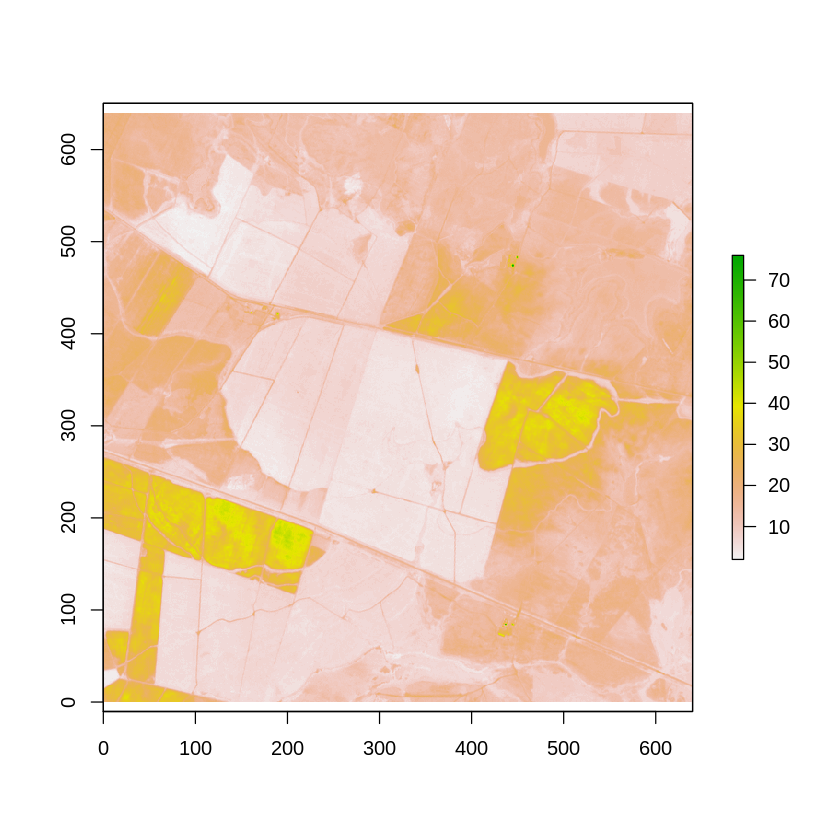

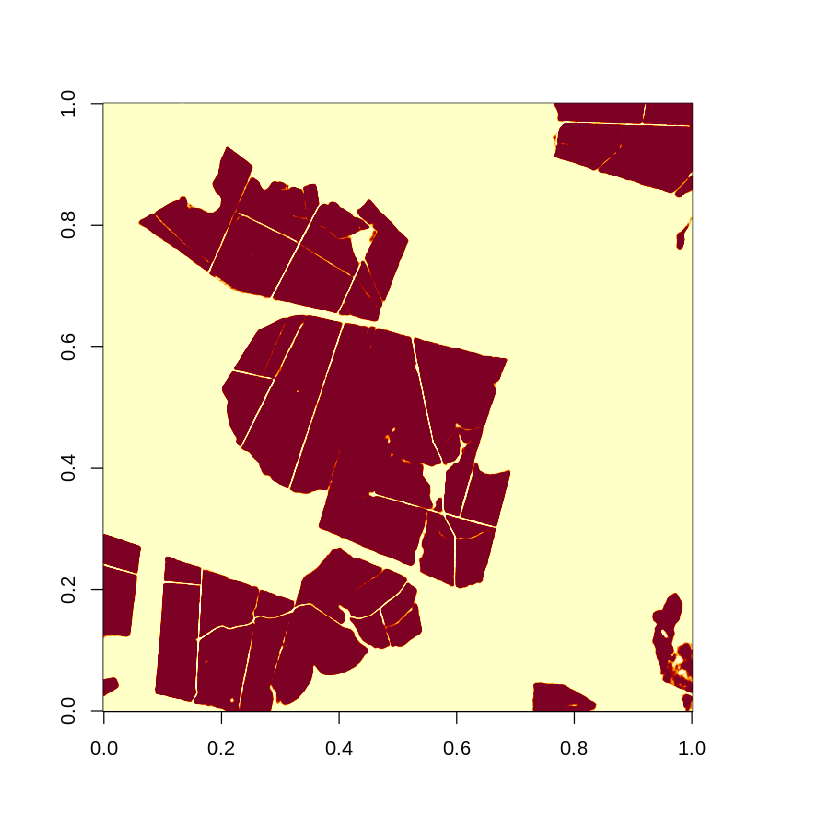

In [ ]:
#@title Visualize some random examples

# list files
list_png=list.files(test_dir, pattern = "*.png$", full.names = TRUE)
length(list_png)

# plot some example
#i= 20  
i = sample(1:length(list_png), 1) # random example
plot(stack(list_png[i])[[1]])
image(t(apply(preds[i,,,], 2, rev)))

# Final considerations

After predicting we need to download the *preds.RData* file to the local computer to make the final map. We don't do it here because it requires the original imagery (which are heavy) to get the original geospatial coordinates (because we used PNG), and a few GDAL functions which I did not have enough time to test it here. Further ways to improve this code would be to use TIF files instead of PNG so we do not lose the coordinates and its easier to make the outputs.<BR><BR>

I hope you learned something about training/predicting a Deep Learning model with Remote Sensing imagery. :)

Any questions, feel free to contact, contact information is at the top of the page. Welcome to Deep Learning!

# **References**

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 9351, 234–241. https://doi.org/10.1007/978-3-319-24574-4_28

Wagner, F. H., Dalagnol, R., Tagle Casapia, X., Streher, A. S., Phillips, O. L., Gloor, E., & Aragão, L. E. O. C. (2020). Regional Mapping and Spatial Distribution Analysis of Canopy Palms in an Amazon Forest Using Deep Learning and VHR Images. Remote Sensing, 12(14), 2225. https://doi.org/10.3390/rs12142225

Wagner, F. H., Dalagnol, R., Tarabalka, Y., Segantine, T. Y. F., Thomé, R., & Hirye, M. C. M. (2020). U-net-id, an instance segmentation model for building extraction from satellite images-Case study in the Joanopolis City, Brazil. Remote Sensing, 12(10), 1–14. https://doi.org/10.3390/rs12101544